In [ ]:
# default_exp modeling.token_classification

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# modeling.token_classification

> This module contains custom models, loss functions, custom splitters, etc... for token classification tasks like named entity recognition.

In [ ]:
#export
import ast, torch
from transformers import *
from fastai.text.all import *

from blurr.data.all import *
from blurr.modeling.core import *

from seqeval import metrics as seq_metrics

In [ ]:
#hide
import pdb

from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}')

Using GPU #1: GeForce GTX 1080 Ti


## Token classification

The objective of token classification is to predict the correct label for each token provided in the input. In the computer vision world, this is akin to what we do in segmentation tasks whereby we attempt to predict the class/label for each pixel in an image. Named entity recognition (NER) is an example of token classification in the NLP space

In [ ]:
# ensures these cols are represented as lists (rather than string)
df_converters = {'tokens': ast.literal_eval, 'labels': ast.literal_eval, 'nested-labels': ast.literal_eval}

# full nlp dataset
# germ_eval_df = pd.read_csv('./data/task-token-classification/germeval2014ner_cleaned.csv', converters=df_converters)

# demo nlp dataset
germ_eval_df = pd.read_csv('./germeval2014_sample.csv', converters=df_converters)

print(len(germ_eval_df))
germ_eval_df.head()

1000


,id,source,tokens,labels,nested-labels,ds_type
0,0,n-tv.de vom 26.02.2005 [2005-02-26],"[Schartau, sagte, dem, "", Tagesspiegel, "", vom, Freitag, ,, Fischer, sei, "", in, einer, Weise, aufgetreten, ,, die, alles, andere, als, überzeugend, war, "", .]","[B-PER, O, O, O, B-ORG, O, O, O, O, B-PER, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]",train
1,1,welt.de vom 29.10.2005 [2005-10-29],"[Firmengründer, Wolf, Peter, Bree, arbeitete, Anfang, der, siebziger, Jahre, als, Möbelvertreter, ,, als, er, einen, fliegenden, Händler, aus, dem, Libanon, traf, .]","[O, B-PER, I-PER, I-PER, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-LOC, O, O]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]",train
2,2,http://www.stern.de/sport/fussball/krawalle-in-der-fussball-bundesliga-dfb-setzt-auf-falsche-konzepte-1553657.html#utm_source=standard&utm_medium=rss-feed&utm_campaign=sport [2010-03-25],"[Ob, sie, dabei, nach, dem, Runden, Tisch, am, 23., April, in, Berlin, durch, ein, pädagogisches, Konzept, unterstützt, wird, ,, ist, allerdings, zu, bezweifeln, .]","[O, O, O, O, O, O, O, O, O, O, O, B-LOC, O, O, O, O, O, O, O, O, O, O, O, O]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]",train
3,3,stern.de vom 21.03.2006 [2006-03-21],"[Bayern, München, ist, wieder, alleiniger, Top-, Favorit, auf, den, Gewinn, der, deutschen, Fußball-Meisterschaft, .]","[B-ORG, I-ORG, O, O, O, O, O, O, O, O, O, B-LOCderiv, O, O]","[B-LOC, B-LOC, O, O, O, O, O, O, O, O, O, O, O, O]",train
4,4,http://www.fr-online.de/in_und_ausland/sport/aktuell/1618625_Frings-schaut-finster-in-die-Zukunft.html [2008-10-24],"[Dabei, hätte, der, tapfere, Schlussmann, allen, Grund, gehabt, ,, sich, viel, früher, aufzuregen, .]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O]",train


We are only going to be working with small sample from the [GermEval 2014](https://sites.google.com/site/germeval2014ner/data) data set ... so the results might not be all that great :).

In [ ]:
labels = sorted(list(set([lbls for sublist in germ_eval_df.labels.tolist() for lbls in sublist])))
print(labels)

['B-LOC', 'B-LOCderiv', 'B-LOCpart', 'B-ORG', 'B-ORGpart', 'B-OTH', 'B-OTHderiv', 'B-OTHpart', 'B-PER', 'B-PERderiv', 'B-PERpart', 'I-LOC', 'I-LOCderiv', 'I-ORG', 'I-ORGpart', 'I-OTH', 'I-PER', 'O']


In [ ]:
task = HF_TASKS_AUTO.TokenClassification
pretrained_model_name = "bert-base-multilingual-cased"
config = AutoConfig.from_pretrained(pretrained_model_name)

config.num_labels = len(labels)

Notice above how I set the `config.num_labels` attribute to the number of labels we want *our* model to be able to predict. The model will update its last layer accordingly (this concept is essentially transfer learning).

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               task=task, 
                                                                               config=config)
hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

('bert',
 transformers.configuration_bert.BertConfig,
 transformers.tokenization_bert.BertTokenizer,
 transformers.modeling_bert.BertForTokenClassification)

In [ ]:
test_eq(hf_config.num_labels, len(labels))

In [ ]:
hf_batch_tfm = HF_TokenClassBatchTransform(hf_arch, hf_tokenizer)

blocks = (
    HF_TextBlock(hf_arch, hf_tokenizer, hf_batch_tfm=hf_batch_tfm, max_length=128, is_pretokenized=True,
                 tok_kwargs={ 'return_special_tokens_mask': True }), 
    HF_TokenCategoryBlock(vocab=labels)
)

def get_y(inp):
    return [ (label, len(hf_tokenizer.tokenize(str(entity)))) for entity, label in zip(inp.tokens, inp.labels) ]

dblock = DataBlock(blocks=blocks, 
                   get_x=ColReader('tokens'),
                   get_y=get_y,
                   splitter=RandomSplitter())

We have to define a `get_y` that creates the same number of labels as there are subtokens for a particular token. For example, my name "Wayde" gets split up into two subtokens, "Way" and "##de". The label for "Wayde" is "B-PER" and we just repeat it for the subtokens.  This all get cleaned up when we show results and get predictions.

In [ ]:
dls = dblock.dataloaders(germ_eval_df, bs=4)

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2)

,token / target label
0,"[('M', 'O'), ('die', 'O'), ('erste', 'O'), ('deutsche', 'B-LOCderiv'), ('Forschung', 'O'), ('in', 'O'), ('der', 'O'), ('Antarktis', 'B-LOC'), (',', 'O'), ('die', 'O'), ('Georg', 'B-LOC'), ('eröffnet', 'O'), ('.', 'O')]"
1,"[('Im', 'O'), ('hohen', 'O'), ('Norden', 'O'), (',', 'O'), ('so', 'O'), ('heißt', 'O'), ('es', 'O'), (',', 'O'), ('können', 'O'), ('Menschen', 'O'), ('event', 'O'), ('noch', 'O'), ('über', 'O'), (',', 'O'), ('Australien', 'B-LOC'), ('dagegen', 'O'), ('hat', 'O'), ('noch', 'O'), ('höchsten', 'O'), ('zwei', 'O'), ('Monate', 'O'), ('.', 'O')]"


### Metrics

In this section, we'll add helpful metrics for token classification tasks

In [ ]:
#export
def calculate_token_class_metrics(pred_toks, targ_toks, metric_key):
    if (metric_key == 'accuracy'): return seq_metrics.accuracy_score(targ_toks, pred_toks)
    if (metric_key == 'precision'): return seq_metrics.precision_score(targ_toks, pred_toks)
    if (metric_key == 'recall'): return seq_metrics.recall_score(targ_toks, pred_toks)
    if (metric_key == 'f1'): return seq_metrics.f1_score(targ_toks, pred_toks)
        
    if (metric_key == 'classification_report'): return seq_metrics.classification_report(targ_toks, pred_toks)
        

### Training

In [ ]:
#export
class HF_TokenClassCallback(HF_BaseModelCallback):
    """A fastai friendly callback that includes accuracy, precision, recall, and f1 metrics using the
    `seqeval` library.  Additionally, this metric knows how to *not* include your 'ignore_token' in it's
    calculations.
    
    See [here](https://github.com/chakki-works/seqeval) for more information on `seqeval`.
    """
    def __init__(self, tok_metrics=["accuracy", "precision", "recall", "f1"], **kwargs):
        self.run_before = Recorder
        
        store_attr(self, 'tok_metrics, kwargs')
        self.custom_metrics_dict = { k:None for k in tok_metrics }
        
        self.do_setup = True
        
    def setup(self):
        # one time setup code here.
        if (not self.do_setup): return
        
        # grab the hf_tokenizer from the target's HF_TokenizerTransform (used for rouge metrics)
        hf_textblock_tfm = self.dls.tfms[0]
        self.hf_tokenizer = hf_textblock_tfm.hf_tokenizer
        self.ignore_label_token_id = self.dls.tfms[1].ignore_token_id
        self.tok_special_symbols = list(self.hf_tokenizer.special_tokens_map.values())
        self.tok_kwargs = hf_textblock_tfm.kwargs
        
        # add custom text generation specific metrics
        custom_metric_keys = self.custom_metrics_dict.keys()
        custom_metrics = L([ ValueMetric(partial(self.metric_value, metric_key=k), k) for k in custom_metric_keys ])
        self.learn.metrics = self.learn.metrics + custom_metrics
        self.learn.token_classification_report = None
        
        self.do_setup = False
        
    def before_fit(self): self.setup()
    
    
    # --- batch begin/after phases ---
    def after_batch(self):
        if (self.training or self.learn.y is None): return
        
        # do this only for validation set
        preds = self.pred.argmax(dim=-1)
        targs = self.yb[0] # yb is TensorText tuple, item 0 is the data
        
        preds_list, targets_list = [], []   
        for i in range(targs.shape[0]):
            item_targs, item_preds = [], []
            
            for j in range(targs.shape[1]):
                if (targs[i, j] != self.ignore_label_token_id):
                    item_preds.append(self.dls.vocab[preds[i][j].item()])
                    item_targs.append(self.dls.vocab[targs[i][j].item()])
                    
            preds_list.append(item_preds)
            targets_list.append(item_targs)
            
        self.results += [ (res[0], res[1]) for res in zip(preds_list, targets_list) ]
        
        
    # --- validation begin/after phases ---
    def before_validate(self): self.results = []
        
    def after_validate(self):
        if (len(self.results) < 1): return
        
        preds, targs = map(list, zip(*self.results))
        for k in self.custom_metrics_dict.keys(): 
            self.custom_metrics_dict[k] = calculate_token_class_metrics(targs, preds, metric_key=k)
        
        self.learn.token_classification_report = calculate_token_class_metrics(targs, preds, 'classification_report')
        
        
    # --- for ValueMetric metrics ---
    def metric_value(self, metric_key): return self.custom_metrics_dict[metric_key]

In [ ]:
model = HF_BaseModelWrapper(hf_model)

learn = Learner(dls, 
                model,
                opt_func=partial(Adam, decouple_wd=True),
                cbs=[HF_TokenClassCallback],
                splitter=hf_splitter)


learn.create_opt()             # -> will create your layer groups based on your "splitter" function
learn.freeze()

In [ ]:
# learn.summary()

In [ ]:
b = dls.one_batch()
preds = learn.model(b[0])
len(preds),preds[0].shape

(1, torch.Size([4, 38, 18]))

In [ ]:
len(b), len(b[0]), b[0]['input_ids'].shape, len(b[1]), b[1].shape

(2, 3, torch.Size([4, 38]), 4, torch.Size([4, 38]))

In [ ]:
print(preds[0].view(-1, preds[0].shape[-1]).shape, b[1].view(-1).shape)
test_eq(preds[0].view(-1, preds[0].shape[-1]).shape[0], b[1].view(-1).shape[0])

torch.Size([152, 18]) torch.Size([152])


In [ ]:
print(len(learn.opt.param_groups))

4


SuggestedLRs(lr_min=0.0006309573538601399, lr_steep=2.0892961401841603e-05)

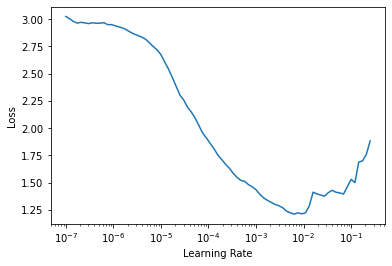

In [ ]:
#slow
learn.unfreeze()
learn.lr_find(suggestions=True)

In [ ]:
#slow
learn.fit_one_cycle(3, lr_max= 3e-5, moms=(0.8,0.7,0.8))

epoch,train_loss,valid_loss,accuracy,precision,recall,f1,time
0,0.302354,0.226072,0.934595,0.388186,0.363636,0.375510,00:19
1,0.131199,0.126418,0.964324,0.713080,0.637736,0.673307,00:19
2,0.071447,0.116839,0.973784,0.725738,0.735043,0.730361,00:19


In [ ]:
#slow
print(learn.token_classification_report)

           precision    recall  f1-score   support

      PER       0.94      0.89      0.91        53
      LOC       0.85      0.69      0.76        58
      ORG       0.75      0.67      0.71        67
      OTH       0.52      0.71      0.60        31
 LOCderiv       0.89      0.70      0.78        23
  LOCpart       0.33      1.00      0.50         2

micro avg       0.73      0.74      0.73       234
macro avg       0.80      0.74      0.76       234



### Showing results

Below we'll add in additional functionality to more intuitively show the results of our model.

In [ ]:
#export
@typedispatch
def show_results(x:HF_TokenClassInput, y:HF_TokenTensorCategory, samples, outs, learner=None, 
                 ctxs=None, max_n=6, **kwargs):    
    # grab tokenizer
    hf_textblock_tfm = learner.dls.tfms[0]
    hf_tokenizer = hf_textblock_tfm.hf_tokenizer
    
    res = L()
    for inp, trg, sample, pred in zip(x[0], y, samples, outs):
        inp_trg_preds = [ (hf_tokenizer.ids_to_tokens[tok_id.item()], lbl_id.item(), pred_lbl) 
                         for tok_id, lbl_id, pred_lbl in zip(inp, trg, ast.literal_eval(pred[0])) 
                         if (tok_id not in hf_tokenizer.all_special_ids) and lbl_id != -100 ]
        
        res.append([f'{[ (itp[0], lbl, itp[2]) for itp, lbl in zip(inp_trg_preds, ast.literal_eval(sample[1])) ]}'])
        
    display_df(pd.DataFrame(res, columns=['token / target label / predicted label'])[:max_n])
    return ctxs

In [ ]:
learn.show_results(learner=learn, max_n=2)

,token / target label / predicted label
0,"[('Damit', 'O', 'O'), ('konnte', 'O', 'O'), ('man', 'O', 'O'), ('allerdings', 'O', 'O'), ('nichts', 'O', 'O'), ('an', 'O', 'O'), ('«', 'O', 'O'), (',', 'O', 'O'), ('mein', 'O', 'O'), ('Helmut', 'B-PER', 'B-PER'), ('Bit', 'I-PER', 'I-PER'), ('und', 'O', 'O'), ('lac', 'O', 'O'), ('.', 'O', 'O')]"
1,"[('Verlag', 'O', 'O'), ('sich', 'O', 'O'), ('die', 'O', 'O'), ('Ko', 'O', 'O'), ('weg', 'O', 'O'), ('von', 'O', 'O'), ('einer', 'O', 'O'), ('Ko', 'O', 'O'), ('zwischen', 'O', 'O'), ('Unternehmen', 'O', 'O'), ('einer', 'O', 'O'), ('Branch', 'O', 'O'), ('hin', 'O', 'O'), ('zu', 'O', 'O'), ('einer', 'O', 'O'), ('Ko', 'O', 'O'), ('zwischen', 'O', 'O'), ('kapital', 'O', 'O'), ('National', 'O', 'O'), ('und', 'O', 'O'), ('Kap', 'O', 'O'), (',', 'O', 'O'), ('nimmt', 'O', 'O'), ('sie', 'O', 'O'), ('mehr', 'O', 'O'), ('und', 'O', 'O'), ('mehr', 'O', 'O'), ('auch', 'O', 'O'), ('militärische', 'O', 'O'), ('Formen', 'O', 'O'), ('an', 'O', 'O'), ('.', 'O', 'O')]"


In [ ]:
res = learn.blurr_predict('My name is Wayde and I live in San Diego'.split())
print(res[0])

['O', 'O', 'O', 'O', 'B-PER', 'B-PER', 'O', 'O', 'O', 'O', 'B-LOC', 'I-LOC', 'O']


The default `Learner.predict` method returns a prediction per subtoken, including the special tokens for each architecture's tokenizer.

In [ ]:
#export
@patch
def blurr_predict_tokens(self:Learner, inp, **kargs):
    """Remove all the unnecessary predicted tokens after calling `Learner.predict`, so that you only
    get the predicted labels, label ids, and probabilities for what you passed into it in addition to the input
    """
    pred_lbls, pred_lbl_ids, probs = self.blurr_predict(inp)

    # grab the huggingface tokenizer from the learner's dls.tfms
    hf_textblock_tfm = self.dls.tfms[0]
    hf_tokenizer = hf_textblock_tfm.hf_tokenizer
    tok_kwargs = hf_textblock_tfm.kwargs
    
    # calculate the number of subtokens per raw/input token so that we can determine what predictions to
    # return
    subtoks_per_raw_tok = [ (entity, len(hf_tokenizer.tokenize(str(entity)))) for entity in inp ]
    
    # very similar to what HF_BatchTransform does with the exception that we are also grabbing
    # the `special_tokens_mask` to help with getting rid or irelevant predicts for any special tokens
    # (e.g., [CLS], [SEP], etc...)
    res = hf_tokenizer(inp, None, 
                       max_length=hf_textblock_tfm.max_length,
                       padding=hf_textblock_tfm.padding,
                       truncation=hf_textblock_tfm.truncation,
                       is_pretokenized=hf_textblock_tfm.is_pretokenized,
                       **tok_kwargs)

    special_toks_msk = L(res['special_tokens_mask'])
    actual_tok_idxs = special_toks_msk.argwhere(lambda el: el != 1)
    
    # using the indexes to the actual tokens, get that info from the results returned above
    pred_lbls_list = ast.literal_eval(pred_lbls)
    actual_pred_lbls = L(pred_lbls_list)[actual_tok_idxs]
    actual_pred_lbl_ids = pred_lbl_ids[actual_tok_idxs]
    actual_probs = probs[actual_tok_idxs]
    
    # now, because a raw token can be mapped to multiple subtokens, we need to build a list of indexes composed
    # of the *first* subtoken used to represent each raw token (that is where the prediction is)
    offset = 0
    raw_trg_idxs = []
    for idx, (raw_tok, sub_tok_count) in enumerate(subtoks_per_raw_tok): 
        raw_trg_idxs.append(idx+offset)
        offset += sub_tok_count-1 if (sub_tok_count > 1) else 0

    return inp, actual_pred_lbls[raw_trg_idxs], actual_pred_lbl_ids[raw_trg_idxs], actual_probs[raw_trg_idxs]

In [ ]:
show_doc(Learner.blurr_predict_tokens)

<h4 id="Learner.blurr_predict_tokens" class="doc_header"><code>Learner.blurr_predict_tokens</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.blurr_predict_tokens</code>(**`inp`**, **\*\*`kargs`**)

Remove all the unnecessary predicted tokens after calling `Learner.predict`, so that you only
get the predicted labels, label ids, and probabilities for what you passed into it in addition to the input

In [ ]:
txt ="Hi! My name is Wayde Gilliam from ohmeow.com. I live in California."

In [ ]:
res = learn.blurr_predict_tokens(txt.split())
print([(tok, lbl) for tok,lbl in zip(res[0],res[1])])

[('Hi!', 'O'), ('My', 'O'), ('name', 'O'), ('is', 'O'), ('Wayde', 'B-PER'), ('Gilliam', 'I-PER'), ('from', 'O'), ('ohmeow.com.', 'B-ORG'), ('I', 'O'), ('live', 'O'), ('in', 'O'), ('California.', 'B-LOC')]


It's interesting (and very cool) how well this model performs on English even thought it was trained against a German corpus.

## Cleanup

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.ipynb.
Converted 01_data-core.ipynb.
Converted 01a_data-language-modeling.ipynb.
Converted 01c_data-question-answering.ipynb.
Converted 01d_data-token-classification.ipynb.
Converted 01e_data-summarization.ipynb.
Converted 02_modeling-core.ipynb.
Converted 02a_modeling-language-modeling.ipynb.
Converted 02c_modeling-question-answering.ipynb.
Converted 02d_modeling-token-classification.ipynb.
Converted 02e_modeling-summarization.ipynb.
Converted index.ipynb.
